In [38]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import math
import timeit
import matplotlib.pyplot as plt

In [39]:
def load_data(path='/content/drive/MyDrive/Colab Notebooks/lemon_dataset', size=0.8):

  x = []
  y = []

  lst_dir = os.listdir(path)

  for dir in lst_dir:

    new_path = path + '/' + dir

    lst_img = os.listdir(new_path)

    for img_name in lst_img:

      x.append(np.asarray(Image.open(new_path + '/' + img_name)))

    y += [lst_dir.index(dir)] * len(lst_img)
  
  n = len(x) // 3
  m = int(n * 0.8)

  x_train = x[: m] + x[n : n + m] + x[2 * n : 2 * n + m]
  y_train = y[: m] + y[n : n + m] + y[2 * n : 2 * n + m]

  x_test = x[m : n] + x[n + m : 2 * n] + x[2 * n + m:]
  y_test = y[m : n] + y[n + m : 2 * n] + y[2 * n + m:]

  return (x_train, y_train), (x_test, y_test)

In [40]:
def adam(parameters, grads, v, s, t, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    L = len(parameters) // 2                
    v_corrected = {}                         
    s_corrected = {}                         

    for l in range(1, L + 1):

        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads['db' + str(l)]

        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - np.power(beta1, t))

        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.power(grads['dW' + str(l)], 2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.power(grads['db' + str(l)], 2)

        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - np.power(beta2, t))

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * (v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon))
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * (v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon))

    return parameters, v, s, v_corrected, s_corrected

In [41]:
def zero_pad(X, pad):

    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values = (0,0))
    
    return X_pad

In [42]:
def conv_backward(dZ, cache, lambd):

    (A_prev, W, hparameters) = cache
    
    (m, n_H_prev, n_W_prev, n_C_prev) =  np.shape(A_prev)
    
    (f, f, n_C_prev, n_C) = np.shape(W)
    
    stride = hparameters['stride_conv']
    pad = hparameters['pad']
    
    (m, n_H, n_W, n_C) = np.shape(dZ)
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                          
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):

        a_prev_pad = A_prev_pad[i, :, :, :]
        da_prev_pad = dA_prev_pad[i, :, :, :]

        for h in range(n_H):

            vert_start = stride * h
            vert_end = stride * h + f

            for w in range(n_W):

                horiz_start = stride * w
                horiz_end = stride * w + f

                for c in range(n_C):

                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]
                    
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]

    #dW += lambd/m * w
    
    return dA_prev, dW, db

In [43]:
def create_mask_from_window(x):

    mask = (x == np.max(x))
    
    return mask

In [44]:
def distribute_value(dz, shape):

    (n_H, n_W) = shape
    
    average = np.prod(shape) 
    a = (dz/average)*np.ones(shape)

    return a

In [45]:
def pool_backward(dA, cache, mode = "max"):

    (A_prev, hparameters) = cache
    
    stride = hparameters['stride_pool']
    f = hparameters['f']
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (m , n_H, n_W, n_C) = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):

        a_prev = A_prev[i, :, :, :]

        for h in range(n_H):

            vert_start = stride * h
            vert_end = stride * h + f

            for w in range(n_W):

                horiz_start = stride * w
                horiz_end = stride * w + f

                for c in range(n_C):

                    if mode == "max":

                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]

                    elif mode == "average":

                        da = dA[i, h, w, c]
                        shape = (f,f)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
    
    return dA_prev

In [60]:
def backward_propagation(X, Y, caches, hyparams, lambd):
    
    ((c_Z, c_A, c_W), (p_A), (h_A, h_W)) = caches

    c_dZ = {}
    c_dA = {}
    c_dW = {}
    c_db = {}

    p_dA = {}

    h_dZ = {}
    h_dA = {}
    h_dW = {}
    h_db = {}
  
    m = X.shape[0]

    h_L = len(h_A)
    c_L = len(c_A)

    for i in range(m):

      h_A['A' + str(h_L)][i][Y[i]] -= 1

    h_dZ['dZ' + str(h_L)] = h_A['A' + str(h_L)]
    h_dW['dW' + str(h_L)] = 1. / m * np.dot(h_A['A' + str(h_L - 1)].T, h_dZ['dZ' + str(h_L)])# + lambd/m * h_W['W' + str(h_L)]
    h_db['db' + str(h_L)] = 1. / m * np.sum(h_dZ['dZ' + str(h_L)], axis=0, keepdims=True)
    
    for l in range(h_L - 1, 1, -1):
        
        h_dA['dA' + str(l)] = np.dot(h_dZ['dZ' + str(l + 1)], h_W['W' + str(l + 1)].T)
        h_dZ['dZ' + str(l)] = np.multiply(h_dA['dA' + str(l)], np.int64(h_A['A' + str(l)] > 0))
        h_dW['dW' + str(l)] = 1. / m * np.dot(h_A['A' + str(l - 1)].T, h_dZ['dZ' + str(l)])# + lambd/m * h_W['W' + str(l)]
        h_db['db' + str(l)] = 1. / m * np.sum(h_dZ['dZ' + str(l)], axis=0, keepdims=True)
        
    h_dA['dA1'] = np.dot(h_dZ['dZ2'], h_W['W2'].T)
    h_dZ['dZ1'] = np.multiply(h_dA['dA1'], np.int64(h_A['A1'] > 0))
    h_dW['dW1'] = 1. / m * np.dot(p_A['Afcl'].T, h_dZ['dZ1'])# + lambd/m * h_W['W1']
    h_db['db1'] = 1. / m * np.sum(h_dZ['dZ1'], axis=0, keepdims=True)
        
    p_dA['dAfcl'] = np.dot(h_dZ['dZ1'], h_W['W1'].T)
    p_dA['dA' + str(c_L)] = p_dA['dAfcl'].reshape(p_A['A' + str(c_L)].shape)
    p_dA['dA' + str(c_L)] = pool_backward(p_dA['dA' + str(c_L)], (c_A['A' + str(c_L)], hyparams), mode = "max")
    c_dA['dA' + str(c_L)] = np.multiply(p_dA['dA' + str(c_L)], np.int64(c_Z['Z' + str(c_L)] > 0))
    c_dZ['dZ' + str(c_L)], c_dW['dW' + str(c_L)], c_db['db' + str(c_L)] = conv_backward(c_dA['dA' + str(c_L)], (p_A['A' + str(c_L - 1)], c_W['W' + str(c_L)], hyparams), lambd)

    for l in range(c_L - 1, 1, -1):

      p_dA['dA' + str(l)] = pool_backward(c_dZ['dZ' + str(l + 1)], (c_A['A' + str(l)], hyparams), mode = "max")
      c_dA['dA' + str(l)] = np.multiply(p_dA['dA' + str(l)], np.int64(c_Z['Z' + str(l)] > 0))
      c_dZ['dZ' + str(l)], c_dW['dW' + str(l)], c_db['db' + str(l)] = conv_backward(c_dA['dA' + str(l)], (p_A['A' + str(l - 1)], c_W['W' + str(l)], hyparams), lambd)

    p_dA['dA1'] = pool_backward(c_dZ['dZ2'], (c_A['A1'], hyparams), mode = "max")
    c_dA['dA1'] = np.multiply(p_dA['dA1'], np.int64(c_Z['Z1'] > 0))
    c_dZ['dZ1'], c_dW['dW1'], c_db['db1'] = conv_backward(c_dA['dA1'], (X, c_W['W1'], hyparams), lambd)

    c_grad = c_dW
    c_grad.update(c_db)
    h_grad = h_dW
    h_grad.update(h_db)

    return (c_grad, h_grad)

In [47]:
def regulizer(w):

  regulizer = 0

  for value in w.values():

    regulizer += np.sum(np.square(value))

  return regulizer

In [48]:
def soft_max(z):
  z = z - np.max(z, axis=1, keepdims=True)
  z = np.exp(z)
  return z / np.sum(z, axis=1, keepdims=True)

In [49]:
def pool_forward(A_prev, hparameters, mode = "max"):

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hparameters["f"]
    stride = hparameters["stride_pool"]
    
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):

        for h in range(n_H):

            vert_start = stride * h
            vert_end = stride * h + f

            for w in range(n_W):

                horiz_start = stride * w
                horiz_end = stride * w + f

                for c in range(n_C):

                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]

                    if mode == "max":

                        A[i, h, w, c] = np.max(a_prev_slice)

                    elif mode == "average":
                      
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    return A

In [50]:
def relu(z):
  return np.where(z > 0, z, 0)

In [51]:
def conv_single_step(a_slice_prev, W, b):

    s = np.multiply(a_slice_prev, W)
    Z = np.sum(s)
    Z = Z + float(b)

    return Z

In [52]:
def conv_forward(A_prev, W, b, hparameters):

    (m, n_H_prev, n_W_prev, n_C_prev) = np.shape(A_prev)
    
    (f, f, n_C_prev, n_C) = np.shape(W)
    
    stride = hparameters['stride_conv']
    pad = hparameters['pad']
    
    n_H = int(((n_H_prev + 2*pad - f) / stride) + 1) 
    n_W = int(((n_W_prev + 2*pad - f) / stride) + 1) 
    
    Z = np.zeros((m, n_H, n_W, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):

        for h in range(n_H):

            vert_start = stride * h
            vert_end = stride * h + f

            for w in range(n_W):

                horiz_start = stride * w
                horiz_end = stride * w + f

                for c in range(n_C):
                  
                    a_slice_prev = A_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c], b[:, :, :, c])
    
    return Z

In [61]:
def forward_propagation(X, Y, c_params, h_params, hyparams, lambd):

  c_A = {}
  c_W = {}
  c_b = {}
  c_Z = {}

  p_A = {}

  h_Z = {}
  h_A = {}
  h_W = {}
  h_b = {}

  c_L = len(c_params) // 2
  m = X.shape[0]

  for l in range(1, c_L + 1):
    
    c_W['W' + str(l)] = c_params['W' + str(l)]
    c_b['b' + str(l)] = c_params['b' + str(l)]

  h_L = len(h_params) // 2

  for l in range(1, h_L + 1):
  
    h_W['W' + str(l)] = h_params['W' + str(l)]
    h_b['b' + str(l)] = h_params['b' + str(l)]

  c_Z['Z1'] = conv_forward(X, c_W['W1'], c_b['b1'], hyparams)
  c_A['A1'] = relu(c_Z['Z1'])
  p_A['A1'] = pool_forward(c_A['A1'], hyparams, mode = "max")

  for l in range(2, c_L):

    c_Z['Z' + str(l)] = conv_forward(p_A['A' + str(l - 1)], c_W['W' + str(l)], c_b['b' + str(l)], hyparams)
    c_A['A' + str(l)] = relu(c_Z['Z' + str(l)])
    p_A['A' + str(l)] = pool_forward(c_A['A' + str(l)], hyparams, mode = "max")


  c_Z['Z' + str(c_L)] = conv_forward(p_A['A' + str(c_L - 1)], c_W['W' + str(c_L)], c_b['b' + str(c_L)], hyparams)
  c_A['A' + str(c_L)] = relu(c_Z['Z' + str(c_L)])
  p_A['A' + str(c_L)] = pool_forward(c_A['A' + str(c_L)], hyparams, mode = "max")

  p_A['Afcl'] = p_A['A' + str(c_L)].reshape(m, -1)

  h_Z['Z1'] = np.dot(p_A['Afcl'], h_W['W1']) + h_b['b1']
  h_A['A1'] = relu(h_Z['Z1'])
    
  for l in range(2, h_L):
      
    h_Z['Z' + str(l)] = np.dot(h_A['A' + str(l - 1)], h_W['W' + str(l)]) + h_b['b' + str(l)]
    h_A['A' + str(l)] = relu(h_Z['Z' + str(l)])
    
  h_Z['Z' + str(h_L)] = np.dot(h_A['A' + str(h_L - 1)], h_W['W' + str(h_L)]) + h_b['b' + str(h_L)]  
  h_A['A' + str(h_L)] = soft_max(h_Z['Z' + str(h_L)])

  log_probs = 0

  for i in range(m):

    log_probs += (-1) * np.log(h_A['A' + str(h_L)][i][Y[i]])

  #regulize = regulizer(c_W) + regulizer(b_W) + regulizer(h_W) 

  cost = (1 / m) * log_probs# + regulize * lambd / (2 * m)
  
  return  cost, ((c_Z, c_A, c_W), (p_A), (h_A, h_W))

In [54]:
def random_mini_batches(X, Y, mini_batch_size = 32):
    
    m = len(X)                 
    mini_batches = []
        
    X = np.array(X, dtype='object')
    Y = np.array(Y, dtype='object')

    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation].tolist()
    shuffled_Y = Y[permutation].tolist()

    inc = mini_batch_size

    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(num_complete_minibatches):
        
        mini_batch_X = shuffled_X[k * inc:(k + 1) * inc]
        mini_batch_Y = shuffled_Y[k * inc:(k + 1) * inc]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[(k + 1) * inc:]
        mini_batch_Y = shuffled_Y[(k + 1) * inc:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
        num_complete_minibatches += 1
    
    return num_complete_minibatches, mini_batches

In [55]:
def initialize_adam(parameters):
    
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(1, L + 1):

        v["dW" + str(l)] = np.zeros(parameters['W' + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters['b' + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters['W' + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters['b' + str(l)].shape)
    
    return v, s

In [65]:
def c_initialize_parames(kernel_size, layers_dims, input_size):
    
    parameters = {}
    n_H, n_W= input_size * 2, input_size * 2
    L = len(layers_dims) - 1
     
    for l in range(1, L + 1):

        n_H, n_W = n_H // 2, n_W // 2
        parameters['W' + str(l)] = np.random.randn(kernel_size, kernel_size, layers_dims[l-1], layers_dims[l]) * np.sqrt(2./layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((1, 1, 1, layers_dims[l]))
        
    return int((n_H / 2)  * (n_W / 2) * layers_dims[-1]), parameters

In [57]:
def h_initialize_params(layers_dims):
    
    parameters = {}
    L = len(layers_dims) - 1
     
    for l in range(1, L + 1):

        parameters['W' + str(l)] = np.random.randn(layers_dims[l-1], layers_dims[l]) * np.sqrt(2./layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((1, layers_dims[l]))
        
    return parameters

In [86]:
def model(X, Y, c_layers_dims, h_layers_dims, kernel_size=(3, 3), input_size=(32, 32, 3), mini_batch_size = 32, hyparams = {"pad" : 1, "stride_conv": 1, "f" : 2, "stride_pool": 2},
          learning_rate = 0.001, lambd = 0.0003, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 50, params = None):
            
    costs = []  
    t = 0  
    if params is None:

      flatten, c_params = c_initialize_parames(kernel_size[0], [input_size[2]] + c_layers_dims, input_size[0])         
      c_v, c_s = initialize_adam(c_params)

      h_params = h_initialize_params([flatten] + h_layers_dims)         
      h_v, h_s = initialize_adam(h_params)   

    else:

      c_params, h_params, _ = params

      c_v, c_s = initialize_adam(c_params)
      h_v, h_s = initialize_adam(h_params)

    for i in range(num_epochs):
        
        m, minibatches = random_mini_batches(X, Y, mini_batch_size)
        cost_total = 0
        
        start = timeit.default_timer()

        for minibatch in minibatches:

            (minibatch_X, minibatch_Y) = minibatch

            minibatch_X = np.array(minibatch_X) / 255
            minibatch_Y = np.array(minibatch_Y)

            cost, caches = forward_propagation(minibatch_X, minibatch_Y, c_params, h_params, hyparams, lambd)

            cost_total += cost
            
            grads = backward_propagation(minibatch_X, minibatch_Y, caches, hyparams, lambd)

            t = t + 1 

            c_params, c_v, c_s, _, _ = adam(c_params, grads[0], c_v, c_s, t, learning_rate, beta1, beta2,  epsilon)

            h_params, h_v, h_s, _, _ = adam(h_params, grads[1], h_v, h_s, t, learning_rate, beta1, beta2,  epsilon)

        cost_avg = cost_total / m
        
        end = timeit.default_timer()
        print(f"Epoch {i+1}/{num_epochs}: {end-start:.4f}", end=" ")
        
        print(f"Cost: {cost_avg:.6f}")
        costs.append(cost_avg)

    plt.plot(costs, label='loss', color='red')
    plt.xlabel('epochs (per 1)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.legend()
    plt.show()

    return (c_params, h_params, hyparams)

In [71]:
def predict(X, Y, parameters):

  (c_params, h_params, hyparams) = parameters

  c_A = {}
  c_W = {}
  c_b = {}
  c_Z = {}

  p_A = {}

  h_Z = {}
  h_A = {}
  h_W = {}
  h_b = {}

  c_L = len(c_params) // 2
  m = X.shape[0]

  for l in range(1, c_L + 1):
    
    c_W['W' + str(l)] = c_params['W' + str(l)]
    c_b['b' + str(l)] = c_params['b' + str(l)]

  h_L = len(h_params) // 2

  for l in range(1, h_L + 1):
  
    h_W['W' + str(l)] = h_params['W' + str(l)]
    h_b['b' + str(l)] = h_params['b' + str(l)]

  c_Z['Z1'] = conv_forward(X, c_W['W1'], c_b['b1'], hyparams)
  c_A['A1'] = relu(c_Z['Z1'])
  p_A['A1'] = pool_forward(c_A['A1'], hyparams, mode = "max")

  for l in range(2, c_L):

    c_Z['Z' + str(l)] = conv_forward(p_A['A' + str(l - 1)], c_W['W' + str(l)], c_b['b' + str(l)], hyparams)
    c_A['A' + str(l)] = relu(c_Z['Z' + str(l)])
    p_A['A' + str(l)] = pool_forward(c_A['A' + str(l)], hyparams, mode = "max")


  c_Z['Z' + str(c_L)] = conv_forward(p_A['A' + str(c_L - 1)], c_W['W' + str(c_L)], c_b['b' + str(c_L)], hyparams)
  c_A['A' + str(c_L)] = relu(c_Z['Z' + str(c_L)])
  p_A['A' + str(c_L)] = pool_forward(c_A['A' + str(c_L)], hyparams, mode = "max")

  p_A['Afcl'] = p_A['A' + str(c_L)].reshape(m, -1)

  h_Z['Z1'] = np.dot(p_A['Afcl'], h_W['W1']) + h_b['b1']
  h_A['A1'] = relu(h_Z['Z1'])
    
  for l in range(2, h_L):
      
    h_Z['Z' + str(l)] = np.dot(h_A['A' + str(l - 1)], h_W['W' + str(l)]) + h_b['b' + str(l)]
    h_A['A' + str(l)] = relu(h_Z['Z' + str(l)])
    
  h_Z['Z' + str(h_L)] = np.dot(h_A['A' + str(h_L - 1)], h_W['W' + str(h_L)]) + h_b['b' + str(h_L)]  
  h_A['A' + str(h_L)] = soft_max(h_Z['Z' + str(h_L)])

  return  f"Predict: {h_A['A' + str(h_L)].argmax()}, True: {y}"

In [31]:
(x_train, y_train) , (x_test, y_test) = load_data()

In [32]:
c_layers_dims = [16, 32, 64, 128]
h_layers_dims = [64, 32, 16, 8, 3]

Epoch 1/5: 133.5787 Cost: 0.043234
Epoch 2/5: 134.4512 Cost: 0.032261
Epoch 3/5: 133.5569 Cost: 0.024911
Epoch 4/5: 134.9584 Cost: 0.018385
Epoch 5/5: 135.6099 Cost: 0.017653


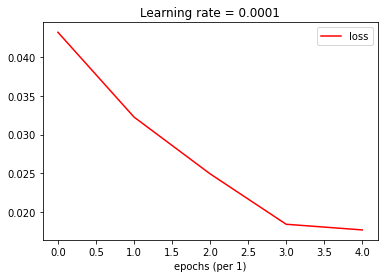

In [99]:
parameters = model(x_train, y_train, c_layers_dims, h_layers_dims, mini_batch_size=4, num_epochs=5, learning_rate=0.0001, params=parameters)

In [100]:
for i in range(len(x_test)):
  x = np.asarray(x_test[i]).reshape(1, 32, 32, 3) / 255
  y = np.asarray(y_test[i])
  print(predict(x, y, parameters))

Predict: 0, True: 0
Predict: 0, True: 0
Predict: 0, True: 0
Predict: 0, True: 0
Predict: 0, True: 0
Predict: 0, True: 0
Predict: 0, True: 0
Predict: 0, True: 0
Predict: 0, True: 0
Predict: 0, True: 0
Predict: 0, True: 0
Predict: 2, True: 1
Predict: 1, True: 1
Predict: 1, True: 1
Predict: 2, True: 1
Predict: 1, True: 1
Predict: 1, True: 1
Predict: 2, True: 1
Predict: 2, True: 1
Predict: 1, True: 1
Predict: 1, True: 1
Predict: 1, True: 1
Predict: 2, True: 2
Predict: 2, True: 2
Predict: 2, True: 2
Predict: 2, True: 2
Predict: 1, True: 2
Predict: 2, True: 2
Predict: 2, True: 2
Predict: 2, True: 2
Predict: 2, True: 2
Predict: 1, True: 2
Predict: 2, True: 2
Predict: 2, True: 2
